# Decision Tree from Scratch

In [1]:
import numpy as np
import urllib
from urllib.request import urlopen
import pandas as pd
import time 
from scipy.stats import entropy
from scipy.stats import mode

In [2]:
#helper function to read the file
def read_file(filename):
    temping = []
    with open(filename) as f:
        for line in f:
            temp = list(map(float, line.split(' ')[:-1]))
            temping.append(temp)
    return np.array(temping)

In [3]:
def split_label(x):
    temping = []
    temping2 = []
    for i in x:
        temping.append(i[:-1])
        temping2.append(i[-1])
    return np.array(temping),np.array(temping2)

In [4]:
#read the train set, test set, validation set.
train_data = read_file('train_set.txt')
test_data = read_file('test_set.txt')
validation_data = read_file('validation_set.txt')

In [5]:
x_train, y_train = split_label(train_data)
x_valid, y_valid= split_label(validation_data)
x_test, y_test= split_label(test_data)

In [8]:
class mytree_node():
    def __init__(self):
        self.parent = None
        self.left = None
        self.right = None
        self.label = -1  
        self.leaf = False
        self.data = None
        self.numdata = -1
        self.labelside = 'root'
        self.threshold = -1
        self.feature = -1

class mytree():
    def __init__(self):
        self.parent = mytree_node()
        
    def check_pure(self,data):
        #"Checking whether the node is pure"
        if len(np.unique(data[:,-1])) ==1:
            return True
        else:
            return False
        
    def find_threshold(self,feature_data):
        #"find all the threshold"
        unique_value = np.sort(np.unique(feature_data))[::-1]
        first_array = unique_value[0:-1]
        second_array = unique_value[1:]
        difference = (first_array - second_array) / 2
        return first_array - difference
                                                   
    def find_information_gain(self, data, threshold_array):
       # "find the information gain"
        min_threshold = threshold_array[0]
        min_entropy = 10000
        for i in range(len(threshold_array)):
            #start finding entropy
            left = data[data[:,0] < threshold_array[i]]
            #the data where larger than the threshold
            right = data[data[:,0] >= threshold_array[i]]

            #Pr(x=0|Z = left)
            prx0zl = np.sum(left[:,-1] == 0)/len(left)
            #Pr (Z = left )
            przl = len(left)/len(data)
            #Pr(x=1|Z = left)
            prx1zl = np.sum(left[:,-1])/len(left)

            #Pr (Z = right )
            przr = len(right)/len(data)
            #Pr(x=0|Z = right)
            prx0zr = np.sum(right[:,-1] == 0)/len(right)
            #Pr(x=1|Z = right)
            prx1zr = np.sum(right[:,-1])/len(right)

            #H(X|Z = left)
            Hxzl = entropy([prx0zl,prx1zl])
            #H(X|Z = right)
            Hxzr = entropy([prx0zr,prx1zr])
            temp_entropy = przl * Hxzl + przr * Hxzr 
            temp_threshold = threshold_array[i]
            if temp_entropy < min_entropy:
                min_entropy = temp_entropy
                min_threshold = temp_threshold
        return min_threshold,min_entropy
                               
        
    def insert_data(self, data, current_node):
        if self.check_pure(data):
            current_node.leaf = True
            current_node.label = np.unique(data[:,-1])[0]
            current_node.numdata = len(data)
        else:
            #the default selected feature is 0
            selected_feature = 0
            
            #set a very large entropy to replace later
            min_entropy = 10000
            
            #set a very larger default threshold
            selected_threshold = None
            
            for idx_feature in range(len(data[0]) - 1):
                #the index one of the feature and its label
                index_label = [idx_feature, -1]  

                #get the actual data of the feature and its label
                feature_data  = data[:,index_label]
                
                #get the threshold array of the selected feature
                threshold_array = self.find_threshold(feature_data[:,0])
                
                #make sure the the threshold_array exist, otherwise skip
                if len(threshold_array)!=0: 
                    temp_threshold, temp_entropy = self.find_information_gain(feature_data,threshold_array)
                    #keep switching to the small entropy, which increases the information gain
                    if temp_entropy < min_entropy:
                        min_entropy = temp_entropy
                        #keep switch the threshold that contains largest information gain
                        selected_threshold = temp_threshold
                        #keep switch the feature that contains largest information gain
                        selected_feature = idx_feature


            left_child = data[data[:, selected_feature] < selected_threshold]
            right_child = data[data[:, selected_feature] >= selected_threshold]
            
            #set up the current node
            current_node.feature = selected_feature
            current_node.data = data
            current_node.numdata = len(data)
            current_node.threshold = selected_threshold
           # current_node.check_node()
            
            #current node child
            current_node.left = mytree_node()
            current_node.left.parent = current_node
            current_node.left.labelside = "left"
            self.insert_data(left_child, current_node.left)
            
            current_node.right = mytree_node()
            current_node.right.parent = current_node
            current_node.right.labelside = "right"
            self.insert_data(right_child,current_node.right)
                      
    def topview(self, root,level, toplevel) :
        print("(level "+ str(level)+" )" + level * "  "  
              + str(root.labelside) + ': Is this a leaf: ' + str(root.leaf)
              + "! The feature at "+str(root.feature+1) + " less than " 
              + str(root.threshold)+ ". The number of data point is " + str(root.numdata)+'\n')
        if level < toplevel -1:
            if root.left.leaf == False:
                self.topview(root.left, level+1,toplevel)
            if root.right.leaf == False:
                self.topview(root.right, level+1,toplevel)
        return None
    
    def predict_error(self, dataset, labelset):
    #dataset represents the data you want to predict
        result = []
        for i in dataset:
            root = self.parent
            while root.leaf == False:
                if i[root.feature] < root.threshold:
                    root = root.left
                else:
                    root = root.right
            #print(root.label)
            result.append(root.label)
        return 1-(sum(np.array(result) == labelset)/len(labelset))
     
    def prune(self,num_prune, x_valid,y_valid,x_test,y_test):
        line = [self.parent]
        n=0
        while len(line)!=0:
            #the current error
            current_error = self.predict_error(x_valid,y_valid)

            prune_node = line.pop(0)
            
            #creating a new node
            new_node = mytree_node()
            new_node.parent = prune_node.parent
            new_node.right = prune_node.right
            new_node.label = prune_node.label
            new_node.data = prune_node.data
            new_node.numdata = prune_node.numdata
            new_node.leaf = prune_node.leaf
            new_node.labelside = prune_node.labelside
            new_node.threshold = prune_node.threshold
            new_node.left = prune_node.left
            new_node.feature = prune_node.feature
            
            #prune the child
            prune_node.left = None
            prune_node.right = None
            prune_node.leaf = True
            prune_node.label = mode(prune_node.data[:,-1]).mode[0]
            
            #error after prune
            after_error =self.predict_error(x_valid, y_valid)
            
            #compare two error
            if current_error >= after_error:
                #the node does need to prune and get the view error
                n+=1
                if n < num_prune + 1:
                    print('# '+str(n) +' pruning: new valid error is: '+str(after_error.round(3)))
                    print('# '+str(n) +' pruning: new test error is: '+str(self.predict_error(x_test,y_test).round(3)))     
   
                else:
                    #break the while loop
                    return None
            else:
                #the node does not need to prune and keep append the its child to the line
                if new_node.left.leaf == False:
                    line.append(new_node.left)
                if new_node.right.leaf == False:
                    line.append(new_node.right)
                if prune_node.labelside == 'root':
                    #if prune node is the root
                    self.parent = new_node
                    new_node.left.parent = self.parent
                    new_node.right.parent = self.parent
                if prune_node.labelside == 'left':
                    #if prune node is left node
                    prune_node.parent.left = new_node
                if prune_node.labelside == 'right':
                    #if prune node is right node
                    prune_node.parent.right = new_node

            
    def check_salient_feature(self,root,level,toplevel):
        feature_list=[root.feature]
        if level < toplevel -1:
            if root.left.leaf == False:
                feature_list+= self.check_salient_feature(root.left, level+1,toplevel)
            if root.right.leaf == False:
                feature_list+=self.check_salient_feature(root.right, level+1,toplevel)
        return feature_list
                    

In [9]:
tree = mytree()

In [10]:
%time tree.insert_data(train_data, tree.parent)

CPU times: user 17.7 s, sys: 17.3 ms, total: 17.7 s
Wall time: 17.7 s


### 1. First, build an ID3 Decision Tree classifier based on the data in train_set.txt. Do not use pruning.Draw the first three levels decision tree that you obtain.

In [11]:
tree.topview(tree.parent, 0, 3)

(level 0 )root: Is this a leaf: False! The feature at 5 less than 0.5. The number of data point is 2000

(level 1 )  left: Is this a leaf: False! The feature at 1 less than 415000.0. The number of data point is 1319

(level 2 )    left: Is this a leaf: False! The feature at 17 less than 2506.5. The number of data point is 1284

(level 2 )    right: Is this a leaf: False! The feature at 21 less than 208.0. The number of data point is 35

(level 1 )  right: Is this a leaf: False! The feature at 5 less than 1.5. The number of data point is 681

(level 2 )    left: Is this a leaf: False! The feature at 20 less than 584.5. The number of data point is 292

(level 2 )    right: Is this a leaf: False! The feature at 21 less than 2006.0. The number of data point is 389



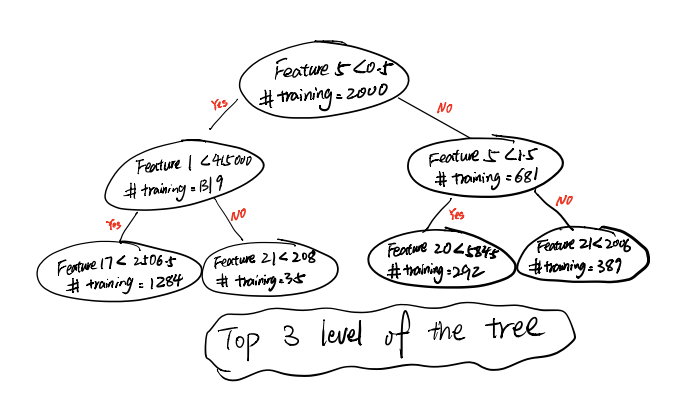

In [12]:
from IPython.display import Image
Image(filename='threelevel.png')

### 2. What is the training and test error of your classifier in part (1), where test error is measured on the data in test_set.txt?

In [13]:
trainset_error = tree.predict_error(x_train,y_train)
testset_error = tree.predict_error(x_test,y_test)

In [14]:
d = {'trainset_error':[trainset_error],'testset_error':[testset_error]}
pd.DataFrame(d)

,trainset_error,testset_error
0,0.0,0.173


### 3. Now, prune the decision tree using the data in validation_set.txt. While selecting nodes to prune, select them in Breadth-First order, going from left to right.

In [15]:
tree.prune(2,x_valid,y_valid,x_test,y_test)

# 1 pruning: new valid error is: 0.122
# 1 pruning: new test error is: 0.117
# 2 pruning: new valid error is: 0.107
# 2 pruning: new test error is: 0.103


### 4. features.txt file provides a description in order of each of the features – that is, it tells you what each coordinate means. Based on the feature descriptions, find the most salient or prominent feature that predicts credit card default. 

In [16]:
def read_file_4(filename):
    temping = []
    with open(filename) as f:
        for line in f:
            temp = list(line[:-1].split(' '))
            #temp = line.split(' ')
            temping.append(temp)
    return np.array(temping)

In [17]:
pa2feature = read_file_4('features.txt')

In [18]:
pa2feature

array([['LIMIT_BAL'],
       ['SEX'],
       ['COLLEGE_ABOVE'],
       ['AGE'],
       ['PAYMENT_DELAY_SEPTEMBER'],
       ['PAYMENT_DELAY_AUGUST'],
       ['PAYMENT_DELAY_JULY'],
       ['PAYMENT_DELAY_JUNE'],
       ['PAYMENT_DELAY_MAY'],
       ['PAYMENT_DELAY_APRIL'],
       ['BILL_AMT1'],
       ['BILL_AMT2'],
       ['BILL_AMT3'],
       ['BILL_AMT4'],
       ['BILL_AMT5'],
       ['BILL_AMT6'],
       ['PAY_AMT1'],
       ['PAY_AMT2'],
       ['PAY_AMT3'],
       ['PAY_AMT4'],
       ['PAY_AMT5'],
       ['PAY_AMT6']], dtype='<U23')

The most revelent feature should be the feature of the root since it splits largest amount of data, which is shown on the figure I drew in question 1.

In [19]:
pa2feature[tree.parent.feature]

array(['PAYMENT_DELAY_SEPTEMBER'], dtype='<U23')

The most salient feature should be PAYMENT_DELAY_SEPTEMBER